# GERMS-ML

## Meeting #5: Groundwater Revisited

This week will be more coding focused. We're going to several different classifiers to the MNIST dataset and Jae's dataset.


### The Groundwater dataset

Let's revisit the groundwater data set. We didn't actually make it predictions last time. We'll skip through the preprocessing and move to predictions.

#### Preprocessing

This time, we'll only read in the 3-month-adjusted dataset:

In [1]:
%matplotlib inline
import pandas as pd
gw = pd.read_excel("../data/gw.xlsx", sheet_name = "Raw_Sorted_3month",
                  skiprows = [0])

Let's drop the non-numeric data for now:

In [2]:
gw.drop(["Internal Wel lID", "Date"], axis = 1,
                                   inplace = True)

Let's check how much data is missing in each category:

In [3]:
import sys
sys.path.insert(0, '../src/')
from gml_utils.preprocessing import get_missing_percentage
missing_percentage = get_missing_percentage(gw)
missing_percentage.sort_values(by = "percent_missing", ascending = False)

,percent_missing
NO2,22.994652
Ferrous,16.042781
tDCE,4.278075
Chloride,3.208556
NO3,3.208556
Redox,2.139037
DO,0.534759
pH,0.534759
Methane,0.000000
TCE,0.000000


Doesn't look too bad - most of the data is there, and there are enough values in the columns with higher missing percentages for us to impute missing values. 

Before we do get started with data preprocessing, let's split the data into a testing and training set. First, we separate our data into attributes and target sets. Our target is `DP (3month later)`, and the remaining columns will be our attributes:

In [4]:
gw_targets = gw["DP (3month later)"]
gw_targets.shape

(187,)

In [5]:
gw_attributes = gw.drop(columns = "DP (3month later)")

Now we split the data into testing and training sets:

In [6]:
from sklearn.model_selection import train_test_split

gw_x_train, gw_x_test, gw_y_train, gw_y_test = train_test_split(
    gw_attributes, gw_targets, test_size = 0.2, random_state = 489
)

Last time, before we did any training on the dataset, we did imputation followed by standardization. Let's make a pipeline to do this for us.

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

gw_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = "median")),
    ("standardization", StandardScaler())
])

Now all we need to do is call `fit_transform` on our training data and it will be preprocessed. Let's look at the values before...

In [8]:
gw_x_train.describe()

,PCE,TCE,cDCE,tDCE,VC,Ethene,Dhc16S,Methane,pH,DO,Redox,NO3,NO2,Ferrous,Sulfate,TOC,Chloride
count,149.000000,149.000000,149.000000,143.000000,149.000000,149.000000,1.490000e+02,149.000000,149.000000,149.000000,147.000000,143.000000,115.000000,126.000000,149.000000,149.000000,143.000000
mean,1888.068389,304.903785,1207.266577,64.846783,1218.371409,472.142311,1.087982e+06,3484.081101,6.759732,1.926242,-68.503673,2.859741,0.589400,4.794603,46.659430,494.163490,65.279371
std,12679.776643,1204.025864,4626.077043,262.590985,4263.934981,2097.181516,5.894971e+06,5910.758338,0.563965,4.359515,100.070519,6.866195,1.113918,16.665491,87.338674,1457.250963,81.922656
min,0.000000,0.250000,0.350000,0.000000,0.340000,0.010000,1.000000e+01,0.013000,5.610000,0.020000,-445.000000,0.040000,0.100000,0.000000,0.000000,0.800000,2.400000
25%,0.550000,1.000000,14.900000,0.410000,2.200000,0.500000,6.770000e+01,38.000000,6.500000,0.340000,-116.350000,0.500000,0.500000,0.042500,5.000000,6.650000,22.800000
50%,1.700000,10.000000,110.000000,1.000000,64.600000,4.460000,2.000000e+04,613.000000,6.670000,0.610000,-78.200000,0.500000,0.500000,0.390000,29.000000,14.200000,32.800000
75%,9.700000,74.000000,800.000000,6.500000,310.000000,99.200000,2.800000e+05,4500.000000,6.860000,1.880000,-25.500000,2.000000,0.500000,1.192500,56.500000,59.300000,72.100000
max,108700.000000,10000.000000,51000.000000,2100.000000,38000.000000,19200.000000,5.500000e+07,34600.000000,9.160000,47.100000,226.800000,63.900000,12.000000,100.000000,666.000000,8300.000000,460.000000


...and compare them to the values after our preprocessing pipeline:

In [9]:
gw_x_train = pd.DataFrame(gw_pipeline.fit_transform(gw_x_train),
                          columns = gw_x_train.columns)

In [10]:
gw_x_train.describe()

,PCE,TCE,cDCE,tDCE,VC,Ethene,Dhc16S,Methane,pH,DO,Redox,NO3,NO2,Ferrous,Sulfate,TOC,Chloride
count,1.490000e+02,1.490000e+02,1.490000e+02,1.490000e+02,1.490000e+02,1.490000e+02,1.490000e+02,1.490000e+02,1.490000e+02,1.490000e+02,1.490000e+02,1.490000e+02,1.490000e+02,1.490000e+02,1.490000e+02,1.490000e+02,1.490000e+02
mean,1.862790e-18,2.235348e-18,7.078603e-18,7.451161e-18,-1.266697e-17,6.706045e-18,6.501138e-17,-1.918674e-17,1.473467e-15,4.060883e-17,1.918674e-16,5.960929e-18,-9.742393e-17,3.148116e-17,-9.947300e-17,-1.415721e-17,-4.470697e-18
std,1.003373e+00,1.003373e+00,1.003373e+00,1.003373e+00,1.003373e+00,1.003373e+00,1.003373e+00,1.003373e+00,1.003373e+00,1.003373e+00,1.003373e+00,1.003373e+00,1.003373e+00,1.003373e+00,1.003373e+00,1.003373e+00,1.003373e+00
min,-1.494061e-01,-2.538827e-01,-2.617741e-01,-2.426433e-01,-2.866224e-01,-2.258863e-01,-1.851817e-01,-5.914332e-01,-2.045533e+00,-4.387347e-01,-3.799213e+00,-4.055242e-01,-4.809930e-01,-2.681085e-01,-5.360374e-01,-3.396995e-01,-7.674406e-01
25%,-1.493626e-01,-2.532576e-01,-2.586183e-01,-2.410458e-01,-2.861848e-01,-2.256519e-01,-1.851719e-01,-5.849848e-01,-4.620987e-01,-3.650845e-01,-4.811642e-01,-3.370617e-01,-7.076443e-02,-2.641990e-01,-4.785959e-01,-3.356716e-01,-5.106776e-01
50%,-1.492716e-01,-2.457575e-01,-2.379916e-01,-2.387470e-01,-2.715010e-01,-2.237573e-01,-1.817793e-01,-4.873764e-01,-1.596449e-01,-3.029421e-01,-9.656535e-02,-3.370617e-01,-7.076443e-02,-2.426966e-01,-2.028768e-01,-3.304731e-01,-3.885282e-01
75%,-1.486385e-01,-1.924232e-01,-8.833406e-02,-2.188761e-01,-2.137544e-01,-1.784300e-01,-1.375251e-01,1.724559e-01,1.783916e-01,-1.064283e-02,4.303654e-01,-1.733469e-01,-7.076443e-02,-2.009950e-01,1.130514e-01,-2.994200e-01,1.000693e-01
max,8.452213e+00,8.079390e+00,1.079979e+01,7.939527e+00,8.655311e+00,8.960131e+00,9.176270e+00,5.282040e+00,4.270413e+00,1.039705e+01,2.982244e+00,9.098863e+00,1.172331e+01,6.247765e+00,7.115169e+00,5.374615e+00,4.936188e+00


And we might as well preprocess the testing attributes while we're at it:

In [11]:
gw_x_test = pd.DataFrame(gw_pipeline.fit_transform(gw_x_test),
                        columns = gw_x_train.columns)

We're ready to train some models.

#### Q1

1. We dropped Well ID and Date as unimportant. What potential problems are there by doing this?

#### Random Forest Classifier

We're going to skip right to parameter tuning. You can read about Random Forests [here](https://en.wikipedia.org/wiki/Random_forest). In short, a random forest classifier is a collection of resampled decision trees (or a "bootstrap aggregation" or "bagged"). The idea is that while an individual tree may not be very accurate in terms of predictive powers, a collection of many trees tends to be more accurate when we take the majority vote as the prediction.

The parameters we'll be tuning are:

* `n_estimators` - the number of trees in the forest
* `max_features` - the number of features to consider when looking for the best split

You can read more about these hyperparameters (and all the other ones) at the [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

gw_rf = RandomForestClassifier()

rf_param_grid = [
    {
        'n_estimators': [50 * (i + 1) for i in range(4)],
        'max_features': ['sqrt', 'log2']
    }
]

rf_grid_search = GridSearchCV(gw_rf, rf_param_grid, cv = 5)
rf_grid_search.fit(gw_x_train, gw_y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [50, 100, 150, 200], 'max_features': ['sqrt', 'log2']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

The best score:

In [13]:
rf_grid_search.best_score_

0.785234899328859

The best parameters

In [14]:
rf_grid_search.best_params_

{'max_features': 'log2', 'n_estimators': 150}

Let's see the performance on the test set:

In [15]:
gw_rf = rf_grid_search.best_estimator_

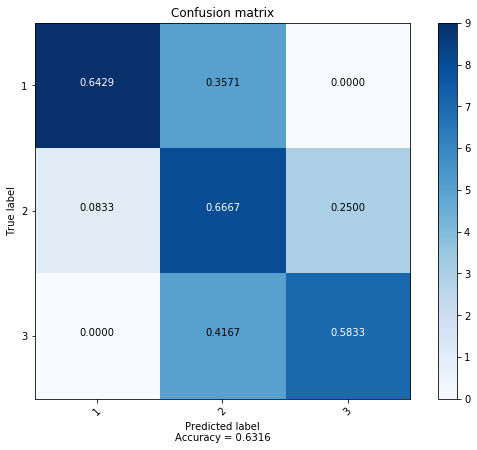

In [16]:
from gml_utils.visualization import get_confusion_matrix
get_confusion_matrix(gw_rf, gw_x_test, gw_y_test)

Yucky.

#### Q4.

1. Tune the random forest.

#### Neural networks

We're going to go ahead and try to use a neural network classifier on this dataset. You can read about the various paramaters for a neural network classifier [here](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier). We're going to start off by tuning the activation function, the hidden layer sizes, and the algorithm used for backpropagation.

Let's create an empty neural network model and the set of parameters we want to check out:

In [17]:
from sklearn.neural_network import MLPClassifier

gw_nn = MLPClassifier()

nn_params = [
    {
        'activation': ['relu', 'logistic'],
        'hidden_layer_sizes': [(10), (10, 10), (10, 10, 10), (10, 10, 10, 10)],
        'solver': ['adam', 'lbfgs']
    }
]

And now we're ready to do our grid search:

In [18]:
nn_grid_search = GridSearchCV(gw_nn, nn_params, cv = 10)
nn_grid_search.fit(gw_x_train, gw_y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/ana

/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/ana

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'activation': ['relu', 'logistic'], 'hidden_layer_sizes': [10, (10, 10), (10, 10, 10), (10, 10, 10, 10)], 'solver': ['adam', 'lbfgs']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Our best performance was:

In [19]:
nn_grid_search.best_score_

0.6241610738255033

And the parameters that gave that best score were:

In [20]:
nn_grid_search.best_params_

{'activation': 'relu', 'hidden_layer_sizes': (10, 10), 'solver': 'adam'}

However, that's not the whole story.

#### Q3

* You should have some errors. What were they? What do they mean? How can we fix them?

There weren't enough iterations to actually reach a convergent solution. A first idea is to increase the number of maximum iterations to see if the model will converge. When we call the `MLPClassifier`, we can set the `max_iter` value to some number that will be shared by all the models we discover during our grid search:

In [21]:
gw_nn = MLPClassifier(max_iter = 5000)

And going back into our gridsearch:

In [22]:
nn_grid_search = GridSearchCV(gw_nn, nn_params, cv = 10)
nn_grid_search.fit(gw_x_train, gw_y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=5000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'activation': ['relu', 'logistic'], 'hidden_layer_sizes': [10, (10, 10), (10, 10, 10), (10, 10, 10, 10)], 'solver': ['adam', 'lbfgs']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

The best score:

In [23]:
nn_grid_search.best_score_

0.6577181208053692

The best parameters:

In [24]:
nn_grid_search.best_params_

{'activation': 'logistic', 'hidden_layer_sizes': 10, 'solver': 'adam'}

The performance is still very bad. What else can we try?

The number of iterations we're using is enough for the models to converge, so we're fairly confident that a good number of hidden layers is 1. Let's see if we can get a good improvement in performance by varying the size of a single layer. We're going to drop the `solver` and `activation` parameters for now, since they have less of an impact on model performance than the architecture of the model itself:

In [25]:
nn_params = [
    {
        'hidden_layer_sizes': [tuple([10 * (i + 1)]) for i in range(20)],
    }
]

In [26]:
gw_nn = MLPClassifier(max_iter = 5000)
nn_grid_search = GridSearchCV(gw_nn, nn_params, cv = 10)
nn_grid_search.fit(gw_x_train, gw_y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=5000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'hidden_layer_sizes': [(10,), (20,), (30,), (40,), (50,), (60,), (70,), (80,), (90,), (100,), (110,), (120,), (130,), (140,), (150,), (160,), (170,), (180,), (190,), (200,)]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

The best score:

In [27]:
nn_grid_search.best_score_

0.6644295302013423

The best parameters:

In [28]:
nn_grid_search.best_params_

{'hidden_layer_sizes': (50,)}

Still yucky. We can continue on like this, constantly adjusting our hyperparameter search space to try and increase our performance. However, we should take a step back and reevaluate whether or not a neural network is the best fit for this problem.

#### Q3.

1. Why is the neural network not getting great results?
2. What are some possible fixes?
3. If you were to continue changing the hyperparameters for this neural network, what might be your next steps?

#### Other models

Let's look at the [`scikit-learn` algorithm cheat-sheet](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) to see what models we might check out next:

![caption](https://scikit-learn.org/stable/_static/ml_map.png)